# **Importing Necessary Packages**

In [ ]:
import torch
import torch.nn as nn

import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
import random

from tqdm.auto import tqdm

print("Pytorch Version:",torch.__version__)
print("GPU Avaiable:",torch.cuda.is_available())

device = 'cuda' if torch.cuda.is_available() == True else 'cpu'
print("Setting device to:",device)


Pytorch Version: 1.8.1+cu101
GPU Avaiable: True
Setting device to: cuda


# **Discriminator Network**

In [ ]:
class Discriminator(nn.Module):
  def __init__(self):
    #initializing parent pytorch class by invoking its __init__() funtion
    super().__init__()
    #defining neural network layer
    self.model = nn.Sequential(
        nn.Linear(4,3),
        nn.Sigmoid(),
        nn.Linear(3,1),
        nn.Sigmoid()
    )
    #create loss function
    self.loss_function = nn.MSELoss()

    #create optimizer, using stochastic gradient descent
    self.optimiser = torch.optim.SGD(self.parameters(), lr=0.01)

    #counter and accumulator for progress
    self.counter = 0
    self.progress = []
    
  
  def forward(self, inputs):
    #simply run the model
    return self.model(inputs)

  def train(self, inputs, targets):
    #calculate the output of the network 
    outputs = self.forward(inputs)
    
    #calculate the loss 
    loss = self.loss_function(outputs, targets)

    #increase the counter of training and accumulate the error in every 10 count
    self.counter += 1
    if (self.counter % 10 == 0):
      self.progress.append(loss.item())

    # zero gradients, perform a backward pass, update weights
    self.optimiser.zero_grad()
    loss.backward()
    self.optimiser.step()
    

    # Finally, we can add a function plot_progress() to draw a chart of the losses accumulated during training
  def plot_progress(self):

    plt.figure(figsize=(16,8))
    plt.plot(self.progress,label="D-Loss")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.title('Loss Vs Iterations');
    plt.show()

# **Generator Network**

In [ ]:
#Defining Generator Neural Network
class Generator(nn.Module):
 
  def __init__(self):
    super().__init__()
    # defining neural network layer
    self.model =  nn.Sequential(
        nn.Linear(1,3),
        nn.Sigmoid(),
        nn.Linear(3,4),
        nn.Sigmoid()
    )

    #create optimizer, using stochastic gradient descent
    self.optimiser = torch.optim.Adam(self.parameters(), lr=0.01)

    #counter and accumulator for progress
    self.counter = 0
    self.progress = []

  def forward(self, inputs):
    #simply run the model
    return self.model(inputs)
  
  def train(self, D, inputs, targets):
    # calculate the output of the network
    g_output = self.forward(inputs)

    # pass onto Discriminator
    d_output = D.forward(g_output)

    # calculate error
    loss = D.loss_function(d_output, targets)
    # increase counter and accumulate error every 10
    self.counter += 1
    if (self.counter % 5 == 0):
      self.progress.append(loss.item())
    

    # zero gradients, perform a backward pass, update weights
    self.optimiser.zero_grad()
    loss.backward()
    self.optimiser.step()
    


# **GAN**

In [ ]:
class GAN:
  def __init__(self):
    self.D = Discriminator().to(device)
    self.G = Generator().to(device)
    self.image_list = []
  
  def generate_real(self):
    real_data = torch.FloatTensor([
                                   random.uniform(0.8,1),
                                   random.uniform(0,0.2),
                                   random.uniform(0.8,1),
                                   random.uniform(0,0.2)
    ]).to(device)
    return real_data

  # creating a function to generate random noise
  def generate_random(self,size):
    random_data = torch.randn(size).to(device)
    return random_data

  def train(self):
    # Training Generator and Discriminator
    for i in tqdm(range(10000)):
      # Training Discriminator in True
      self.D.train(self.generate_real(), torch.FloatTensor([1.0]).to(device))

      #Training Discriminator in False
      #use detach() so gradients in G are not calculated
      self.D.train(self.G.forward(self.generate_random(1).detach()), torch.FloatTensor([0.0]).to(device))
      
      # Training Generator
      self.G.train(self.D,self.generate_random(1), torch.FloatTensor([1.0]).to(device))

      #Storing the Generator ouput loop for visualizing in image_list in every 1000 training cycles
      if (i%100 == 0):
        output = self.G.forward(self.generate_random(1))
        self.image_list.append(output.cpu().detach().numpy())

  def visualize_losses(self):
    plt.figure(figsize=(16,8))
    plt.plot(self.D.progress,label="D-Loss")
    plt.plot(self.G.progress,label="G-loss")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.title('Loss Vs Iterations');
    plt.show()
  
  def visualize_results(self):
    df = pd.DataFrame(np.array(self.image_list),columns=["1st Bit","2nd Bit","3rd Bit", "4th Bit"])
    plt.figure(figsize=(16,8))
    plt.plot(df.iloc[:,0],label = "1st Bit")
    plt.plot(df.iloc[:,1],label = "2nd Bit")
    plt.plot(df.iloc[:,2],label = "3rd Bit")
    plt.plot(df.iloc[:,3],label = "4th Bit")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.title('Generator Process Over Iterations');
    plt.show()

  def show_results(self):
    df = pd.DataFrame(np.array(self.image_list),columns=["1st Bit","2nd Bit","3rd Bit", "4th Bit"])
    print("Results of Generator during Training:")
    print(df)
    
  def generate(self,random_value):
    return self.G.forward(random_value)

# **Training Model**

In [ ]:
model = GAN()
model.train()


# **Visualization of Results and Losses**

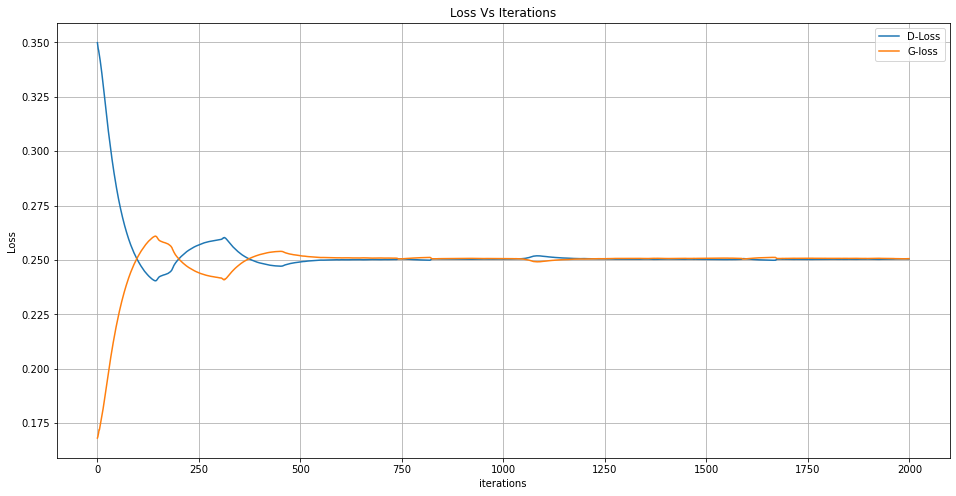

In [ ]:
model.visualize_losses()


In [ ]:
model.show_results()

Results of Generator during Training:
     1st Bit   2nd Bit   3rd Bit   4th Bit
0   0.702231  0.466267  0.485222  0.547122
1   0.116165  0.918032  0.905601  0.079290
2   0.034347  0.970413  0.974493  0.025457
3   0.019901  0.980594  0.992456  0.016338
4   0.015211  0.983019  0.996697  0.012503
..       ...       ...       ...       ...
95  0.999894  0.000065  0.999398  0.001079
96  0.999899  0.000061  0.999447  0.001261
97  0.999899  0.000061  0.999475  0.001580
98  0.999904  0.000057  0.999513  0.001924
99  0.999907  0.000055  0.999541  0.002340

[100 rows x 4 columns]


# **Generating Output From Model**

In [ ]:
random_value = model.generate_random(1)
output = model.generate(random_value).detach().cpu().numpy()
print([ "{:0.2f}".format(x) for x in output ])
print("Therefore, it generate 1010 pattern")

['1.00', '0.00', '1.00', '0.00']
Therefore, it generate 1010 pattern
